In [46]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report

import datetime
import pandas as pd


In [47]:
DATA_DIR = "D:/AI-Powered-Skin-Facial-Condition-Diagnosis-Mobile-Application-main/server/dataset"
MODEL_DIR = "../models"

BATCH_SIZE = 16
NUM_EPOCHS = 15
FREEZE_EPOCHS = 0
LR = 3e-5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'CUDA Available: {torch.cuda.is_available()}'); 
print(f'GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else None}')

os.makedirs(MODEL_DIR, exist_ok=True)


CUDA Available: True
GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [48]:
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=transform)
valid_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "valid"), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

class_names = train_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)


Classes: ['blackheads', 'cysts', 'nodules', 'papules', 'pustules', 'whiteheads']


In [49]:
with open(os.path.join(MODEL_DIR, "dataset_model_classes.json"), "w") as f:
    json.dump({i: name for i, name in enumerate(class_names)}, f)


In [50]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(DEVICE)

# # Freeze backbone
# for param in model.parameters():
#     param.requires_grad = False

# for param in model.fc.parameters():
#     param.requires_grad = True

print("Backbone frozen. Only classifier head is trainable.")


Backbone frozen. Only classifier head is trainable.


In [51]:
class_counts = np.bincount(train_dataset.targets)
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float).to(DEVICE)

# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.1
)


optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

scaler = torch.cuda.amp.GradScaler()


In [52]:
best_val_acc = 0.0
train_losses = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):

    # # Unfreeze after FREEZE_EPOCHS
    # if epoch == FREEZE_EPOCHS:
    #     print("Unfreezing entire network...")
    #     for param in model.parameters():
    #         param.requires_grad = True
    #     optimizer = optim.Adam(model.parameters(), lr=LR)

    model.train()
    running_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for images, labels in train_bar:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_acc = correct / total
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, "best_resnet50.pt"))
        print("Best model saved.")

print("Training Complete. Best Val Acc:", best_val_acc)


Epoch 1/15:   0%|          | 0/117 [00:00<?, ?it/s]

Epoch 1 | Loss: 1.5176 | Val Acc: 0.5858
Best model saved.


Epoch 2/15:   0%|          | 0/117 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.9761 | Val Acc: 0.7238
Best model saved.


Epoch 3/15:   0%|          | 0/117 [00:00<?, ?it/s]

Epoch 3 | Loss: 0.6405 | Val Acc: 0.7364
Best model saved.


Epoch 4/15:   0%|          | 0/117 [00:00<?, ?it/s]

Epoch 4 | Loss: 0.5250 | Val Acc: 0.7824
Best model saved.


Epoch 5/15:   0%|          | 0/117 [00:00<?, ?it/s]

Epoch 5 | Loss: 0.4938 | Val Acc: 0.7615


Epoch 6/15:   0%|          | 0/117 [00:00<?, ?it/s]

Epoch 6 | Loss: 0.4783 | Val Acc: 0.7699


Epoch 7/15:   0%|          | 0/117 [00:00<?, ?it/s]

Epoch 7 | Loss: 0.4731 | Val Acc: 0.7824


Epoch 8/15:   0%|          | 0/117 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.4667 | Val Acc: 0.7699


Epoch 9/15:   0%|          | 0/117 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.4677 | Val Acc: 0.7699


Epoch 10/15:   0%|          | 0/117 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.4650 | Val Acc: 0.7699


Epoch 11/15:   0%|          | 0/117 [00:00<?, ?it/s]

Epoch 11 | Loss: 0.4592 | Val Acc: 0.7908
Best model saved.


Epoch 12/15:   0%|          | 0/117 [00:00<?, ?it/s]

Epoch 12 | Loss: 0.4584 | Val Acc: 0.7824


Epoch 13/15:   0%|          | 0/117 [00:00<?, ?it/s]

Epoch 13 | Loss: 0.4608 | Val Acc: 0.7992
Best model saved.


Epoch 14/15:   0%|          | 0/117 [00:00<?, ?it/s]

Epoch 14 | Loss: 0.4585 | Val Acc: 0.7950


Epoch 15/15:   0%|          | 0/117 [00:00<?, ?it/s]

Epoch 15 | Loss: 0.4559 | Val Acc: 0.7950
Training Complete. Best Val Acc: 0.799163179916318


In [53]:
model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "best_resnet50.pt")))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))



Classification Report:
              precision    recall  f1-score   support

  blackheads       0.48      0.59      0.53        58
       cysts       0.39      0.52      0.44        42
     nodules       0.37      0.26      0.31        57
     papules       0.28      0.24      0.26        54
    pustules       0.54      0.53      0.53        57
  whiteheads       0.45      0.42      0.43        55

    accuracy                           0.42       323
   macro avg       0.42      0.43      0.42       323
weighted avg       0.42      0.42      0.42       323



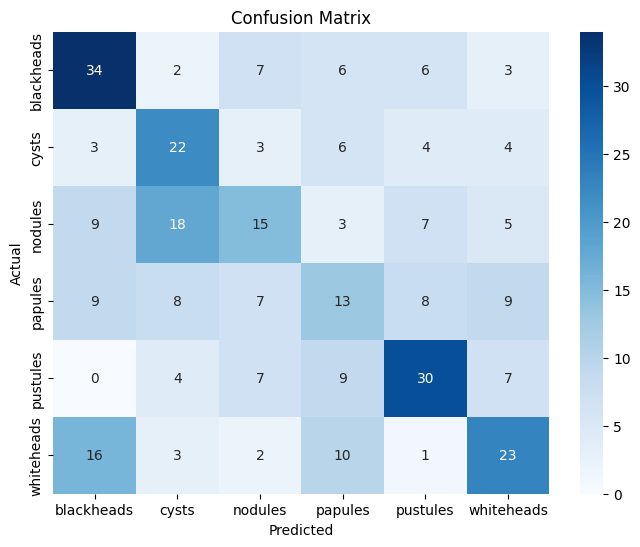

In [54]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


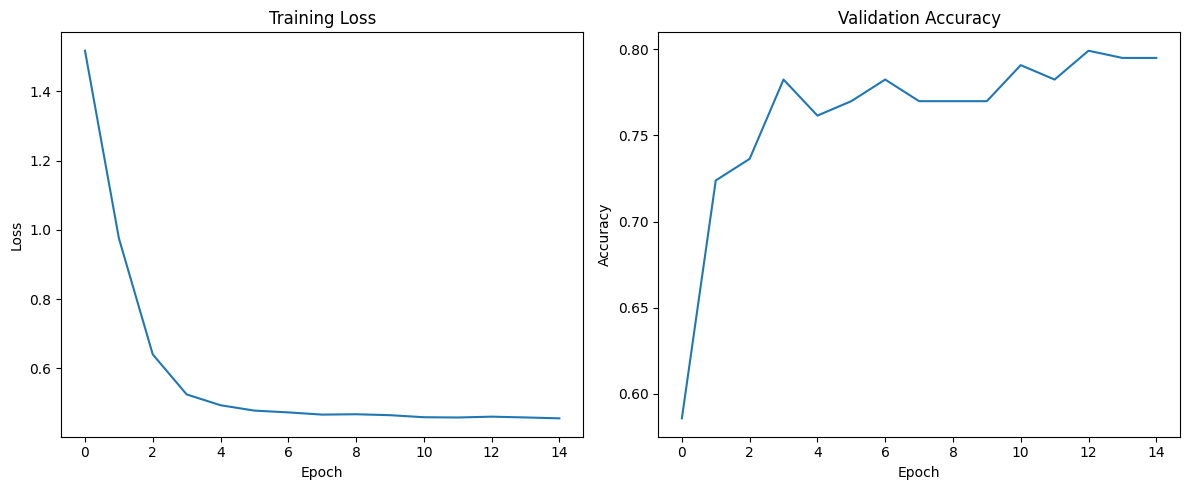

Experiment 8 logged to JSON.
Experiment 8 summary saved to CSV.


In [55]:
final_test_accuracy = float(sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels))
report_dict = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    output_dict=True
)

cm = confusion_matrix(all_labels, all_preds)

log_json_path = os.path.join(MODEL_DIR, "experiment_log.json")
log_csv_path = os.path.join(MODEL_DIR, "experiment_summary.csv")

if os.path.exists(log_json_path):
    with open(log_json_path, "r") as f:
        logs = json.load(f)
    experiment_id = len(logs) + 1
else:
    logs = []
    experiment_id = 1

cm_image_path = os.path.join(MODEL_DIR, f"confusion_matrix_exp_{experiment_id}.png")

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - Experiment {experiment_id}")
plt.savefig(cm_image_path, dpi=300)
plt.close()


curve_image_path = os.path.join(MODEL_DIR, f"training_curves_exp_{experiment_id}.png")

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(val_accuracies)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.savefig(curve_image_path, dpi=300)
plt.show()

experiment_info = {
    "experiment_id": experiment_id,
    "timestamp": str(datetime.datetime.now()),
    "model": "ResNet50",
    "pretrained": True,
    "input_resolution": "320x320",
    "batch_size": BATCH_SIZE,
    "learning_rate": LR,
    "num_epochs": NUM_EPOCHS,
    "freeze_epochs": FREEZE_EPOCHS,
    "optimizer": "Adam",
    "loss_function": "CrossEntropyLoss (with class weights)",
    "class_weights": class_weights.detach().cpu().numpy().tolist(),
    "best_validation_accuracy": float(best_val_acc),
    "final_test_accuracy": final_test_accuracy,
    "final_training_loss": float(train_losses[-1]),
    "num_classes": num_classes,
    "class_names": class_names,
    "per_class_metrics": report_dict,
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_image": cm_image_path,
    "training_curve_image": curve_image_path,
    "training_loss_curve": train_losses,
    "validation_accuracy_curve": val_accuracies
}

logs.append(experiment_info)

with open(log_json_path, "w") as f:
    json.dump(logs, f, indent=4)

print(f"Experiment {experiment_id} logged to JSON.")


summary_row = {
    "experiment_id": experiment_id,
    "model": "ResNet50",
    "input_resolution": "320x320",
    "batch_size": BATCH_SIZE,
    "learning_rate": LR,
    "num_epochs": NUM_EPOCHS,
    "freeze_epochs": FREEZE_EPOCHS,
    "best_validation_accuracy": best_val_acc,
    "final_test_accuracy": final_test_accuracy,
    "final_training_loss": train_losses[-1]
}

summary_df = pd.DataFrame([summary_row])

if os.path.exists(log_csv_path):
    summary_df.to_csv(log_csv_path, mode='a', header=False, index=False)
else:
    summary_df.to_csv(log_csv_path, index=False)

print(f"Experiment {experiment_id} summary saved to CSV.")


In [56]:
from collections import Counter

print("Train distribution:", Counter(train_dataset.targets))
print("Valid distribution:", Counter(valid_dataset.targets))
print("Test distribution:", Counter(test_dataset.targets))


Train distribution: Counter({5: 320, 1: 318, 4: 314, 0: 312, 3: 306, 2: 302})
Valid distribution: Counter({0: 42, 1: 40, 4: 40, 5: 40, 2: 39, 3: 38})
Test distribution: Counter({0: 58, 2: 57, 4: 57, 5: 55, 3: 54, 1: 42})
